# 3 class discrimination of trialtype based on one number. 
## AB trials only
### Using sklean and skflow. Comparison to each of the 4 mice

In [140]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns 
import random
from scipy.signal import resample
from scipy.stats import zscore
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
# data loading function
def data_loader(mouse_name):
    theta = pd.read_csv('~/work/whiskfree/data/theta_' + mouse_name + '.csv',header=None)
    kappa = pd.read_csv('~/work/whiskfree/data/kappa_' + mouse_name + '.csv',header=None)
    tt = pd.read_csv('~/work/whiskfree/data/trialtype_' + mouse_name + '.csv',header=None)
    ch = pd.read_csv('~/work/whiskfree/data/choice_' + mouse_name + '.csv',header=None)

    return theta, kappa, tt, ch

def data_parser(theta,kappa,tt,ch,tt_ch):
    
    theta_r = np.array([[resample(theta.values.squeeze()[i,950:1440],50)] for i in range(0,theta.shape[0])])
    theta_r = zscore(theta_r.squeeze(),axis=None)

    kappa_r = np.array([[resample(kappa.values.squeeze()[i,950:1440],50)] for i in range(0,kappa.shape[0])])
    kappa_r = zscore(kappa_r.squeeze(),axis=None)

    kappa_df = pd.DataFrame(kappa_r)
    theta_df = pd.DataFrame(theta_r)

    both_df = pd.concat([theta_df,kappa_df],axis=1)
    
    if tt_ch == 'tt':
        # trial type
        clean = tt.values !=0
        tt_c = tt[clean.squeeze()].values
    else :
        # choice
        clean = ch.values !=0
        tt_c = ch[clean.squeeze()].values

    # tt_c = tt[tt.values !=0|3].values
    both = both_df.values
    # both_c = both[clean.squeeze(),:]
    both_c = both[clean.squeeze(),:]
    
    # keeping one hot vector for now (incase we want it later)
    labs = np.eye(3)[tt_c.astype(int)-1]
    # y[np.arange(3), a] = 1
    labs = labs.squeeze()
    
    return labs, both_c, tt_c, clean

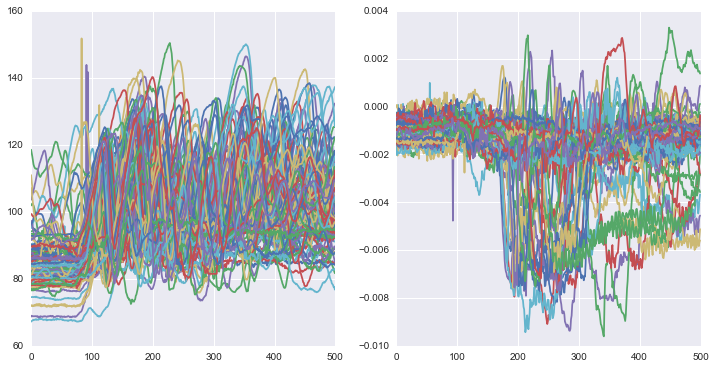

In [226]:
mouse_name = '36'
theta, kappa, tt, ch = data_loader(mouse_name)

fig, ax = plt.subplots(1,2,figsize=(12,6))
_ = ax[0].plot(theta.values[:100,950:1450].T)
_ = ax[1].plot(kappa.values[:100,950:1450].T)

In [227]:
labs_tt, both_tt, tt_c, clean_tt = data_parser(theta,kappa,tt,ch,'tt')
labs_ch, both_h, ch_c, clean_ch = data_parser(theta,kappa,tt,ch,'ch')

In [41]:
# 1. Toy example. Create three gaussian distributed white noise classes with means of -2,0,2. 
# Classify with 2 models: log reg + NN (also NB)
baseclass = np.random.normal?



In [42]:
baseclass = np.random.multivariate_normal?

(-8.0, 8.0, -8.0, 8.0)

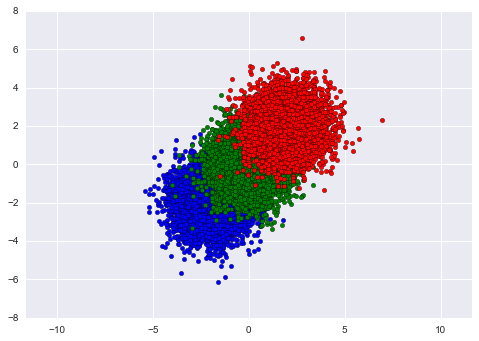

In [30]:
cov = [[1,0],[0,1]]
class1 = np.random.multivariate_normal([-2,-2],cov,5000)
class2 = np.random.multivariate_normal([0,0],cov,5000)
class3 = np.random.multivariate_normal([2,2],cov,5000)
# plt.scatter(x,y)
# plt.axis('equal')
class1.shape
_ = plt.scatter(class1[:,0],class1[:,1],c = 'b')
_ = plt.scatter(class2[:,0],class2[:,1],c = 'g')
_ = plt.scatter(class3[:,0],class3[:,1],c = 'r')
plt.axis('equal')

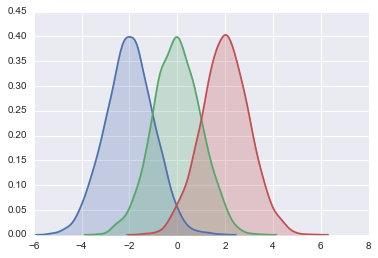

In [149]:
# class1 = np.random.normal(-4,1,1e4)
# class2 = np.random.normal(0,1,1e4)
# class3 = np.random.normal(4,1,1e4)
# _ = plt.hist(class1[:,0],bins=100)
# _ = plt.hist(class2[:,0],bins=100)
# _ = plt.hist(class3[:,0],bins=100)

_ = sns.kdeplot(class1[:,0],shade=True)
_ = sns.kdeplot(class2[:,0],shade=True)
_ = sns.kdeplot(class3[:,0],shade=True)
# sns.kdeplot?

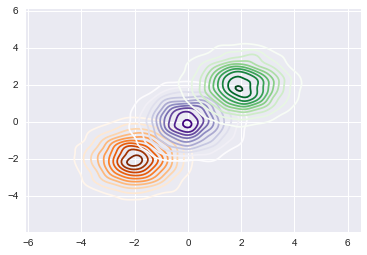

In [148]:
sns.kdeplot(class1,cmap='Oranges')
sns.kdeplot(class2,cmap='Purples')
sns.kdeplot(class3,cmap='Greens')

(15000,)
(15000, 2)


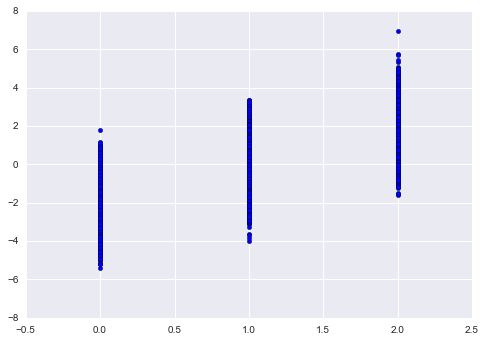

In [31]:
# Concatenate data and create labels array
dataset = np.vstack([class1,class2,class3])
labels = np.hstack([np.zeros(len(class1)),np.ones(len(class2)),2*np.ones(len(class3))])
print(labels.shape)
print(dataset.shape)
# class1.shape
# np.array?
plt.scatter(labels,dataset[:,0])

0.885


(-6.0, 8.0, -6.0, 6.0)

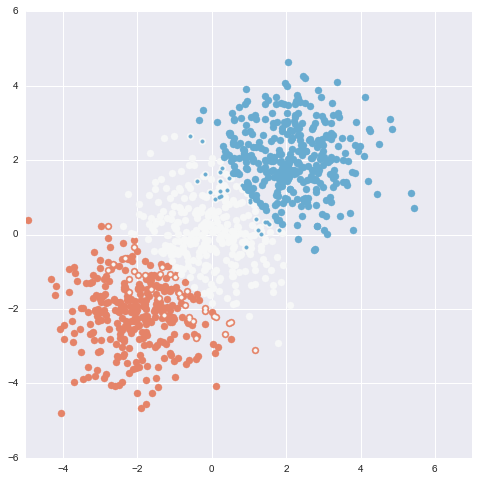

In [34]:
lr = LogisticRegression(solver = 'lbfgs',multi_class = 'multinomial')
train = random.sample(range(len(labels)),500)
lr.fit(dataset[train],labels[train])
test = random.sample(range(len(labels)),1000)
print(accuracy_score(labels[test],lr.predict(dataset[test])))
output = lr.predict(dataset[test])

fig, ax = plt.subplots(figsize=(8,8))
# sns.kdeplot(class1,cmap='Blues')
# sns.kdeplot(class2,cmap='Greens')
# sns.kdeplot(class3,cmap='Reds')

palette = itertools.cycle(sns.color_palette("RdBu",3))

for i in range(0,3):
    c = next(palette)
            
    _ = plt.scatter(dataset[np.array(test)[labels[test] ==i],0],dataset[np.array(test)[labels[test] ==i],1],s = 50,color=c,marker = '.')
    _ = plt.scatter(dataset[np.array(test)[output ==i],0],dataset[np.array(test)[output ==i],1],s = 50, color=c,marker = 'o')
    
plt.axis('equal')

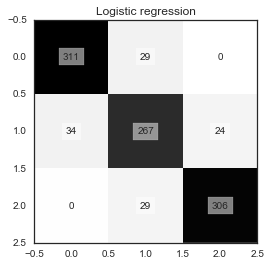

In [195]:
# Confusion matrices
cm_m = confusion_matrix(labels[test],output)
with sns.axes_style("white"):
    plt.imshow(cm_m,interpolation='none',cmap="Greys")
    plt.title('Logistic regression')
    
    for i in range(0,3):
        for j in range(0,3):
            plt.text(i, j, cm_m[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

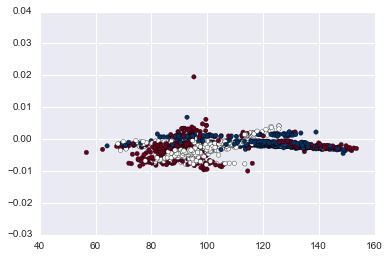

In [228]:
# Repeat the steps but taking kappa(argmax(abs(kappa))) and theta(argmax(abs(kappa))) as the two numbers
kappa_tt = kappa[clean_tt]
theta_tt = theta[clean_tt]
theta.shape
peak = np.argmax(abs(kappa_tt.values[:,950:1450]),1)
theta_peak = np.empty(len(peak))
kappa_peak = np.empty(len(peak))

for i in range(len(kappa_tt)): 
    theta_peak[i] = theta_tt.values[i,peak[i]+950]
    kappa_peak[i] = kappa_tt.values[i,peak[i]+950]

plt.scatter(theta_peak,kappa_peak,c = tt.values[clean_tt],cmap="RdBu")


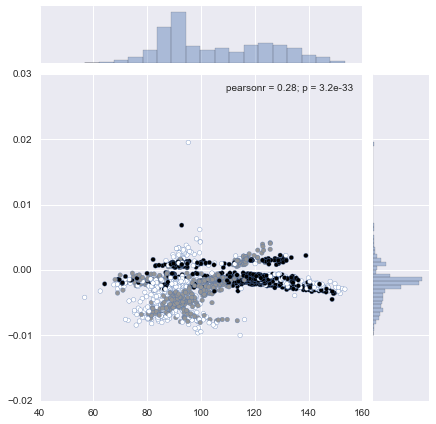

In [237]:
sns.jointplot(theta_peak,kappa_peak, c = tt.values[clean_tt])

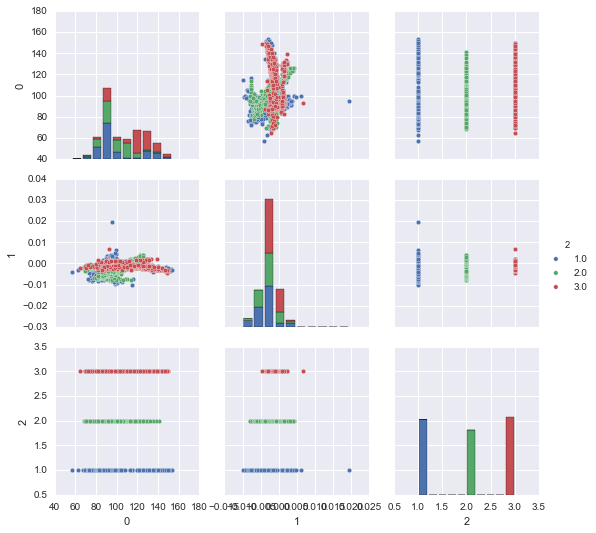

In [238]:
data = pd.DataFrame([theta_peak,kappa_peak,tt.values[clean_tt]])
sns.pairplot(data.T,hue = 2)

In [232]:
print(np.mean(kappa_peak[ch.values[clean_tt]==1]))
print(np.mean(kappa_peak[ch.values[clean_tt]==2]))
print(np.mean(kappa_peak[ch.values[clean_tt]==3]))

-0.00302215784314
-0.00209524588957
-0.00171426481283


/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


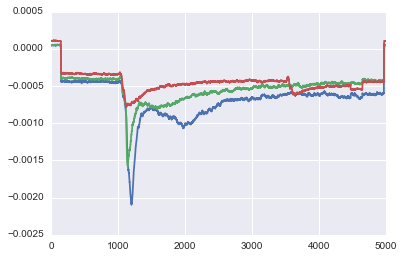

In [233]:
plt.plot(np.mean(kappa_tt[tt.squeeze()==1],0))
plt.plot(np.mean(kappa_tt[tt.squeeze()==2],0))
plt.plot(np.mean(kappa_tt[tt.squeeze()==3],0))

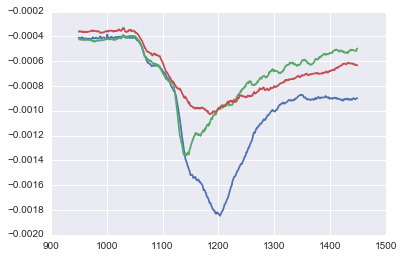

In [239]:
for i in range(3):
    x = np.mean(kappa[ch.values==i+1])
    plt.plot(x[950:1450])
# plt.plot(np.mean(kappa[ch.values==2]))
# plt.plot(np.mean(kappa[ch.values==3]))

In [ ]:
# Order data into data and label arrays
theta_peak,kappa_peak,tt.values[clean_tt]

dataset = np.vstack([class1,class2,class3])
labels = np.hstack([np.zeros(len(class1)),np.ones(len(class2)),2*np.ones(len(class3))])
print(labels.shape)
print(dataset.shape)

In [ ]:
# Now classify trialtype or choice based on theta peak, kappa peak 

lr = LogisticRegression(solver = 'lbfgs',multi_class = 'multinomial')
train = random.sample(range(len(labels)),500)
lr.fit(dataset[train],labels[train])
test = random.sample(range(len(labels)),1000)
print(accuracy_score(labels[test],lr.predict(dataset[test])))
output = lr.predict(dataset[test])

fig, ax = plt.subplots(figsize=(8,8))
# sns.kdeplot(class1,cmap='Blues')
# sns.kdeplot(class2,cmap='Greens')
# sns.kdeplot(class3,cmap='Reds')

palette = itertools.cycle(sns.color_palette("RdBu",3))

for i in range(0,3):
    c = next(palette)
            
    _ = plt.scatter(dataset[np.array(test)[labels[test] ==i],0],dataset[np.array(test)[labels[test] ==i],1],s = 50,color=c,marker = '.')
    _ = plt.scatter(dataset[np.array(test)[output ==i],0],dataset[np.array(test)[output ==i],1],s = 50, color=c,marker = 'o')
    
plt.axis('equal')

## Load pred and resp arrays. Looks like labels of original data might be wrong...

In [60]:
resp = pd.read_csv('~/work/whiskfree/data/resp_' + mouse_name + '.csv',header=None) # Labels
pred = pd.read_csv('~/work/whiskfree/data/pred_' + mouse_name + '.csv',header=None) # Feature vector

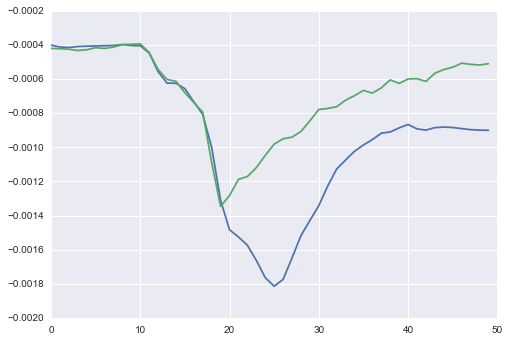

In [110]:
# _ = plt.plot(resp,pred.values[:,72],'.')
# _ = plt.plot(pred.values[:,72])
indeces = np.array(range(len(resp)))
plt.plot(np.mean(pred.values[indeces[resp.values.squeeze()==0],50:100],0))
plt.plot(np.mean(pred.values[indeces[resp.values.squeeze()==1],50:100],0))
# plt.plot(np.mean(pred.values[50:100,resp.values==1],1))

In [174]:
lr2 = LogisticRegression(solver = 'lbfgs',multi_class = 'multinomial')
train = random.sample(range(len(resp)),int(len(resp)/2))
test = np.delete(np.array(range(len(resp))),train)
lr2.fit(pred.values[train],resp.values[train])
print(accuracy_score(resp.values[test],lr2.predict(pred.values[test])))

0.682724252492


/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [187]:
# 5 fold cross validation
scores_lr = cross_validation.cross_val_score(lr2, pred.values.squeeze(), resp.values.squeeze(), cv=5,scoring='f1_weighted')

print(scores_lr)
print(np.mean(scores_lr))

for i in range(10):
    print(np.mean(cross_validation.cross_val_score(lr2, pred.values.squeeze(), resp.values.squeeze(), cv=i+2,scoring='f1_weighted')))

[ 0.70802213  0.66804979  0.6309948   0.70630678  0.64029331]
0.670733364094
0.644007837144
0.652272931823
0.654881146138
0.670733364094
0.667538581511
0.658266665373
0.666955678118
0.670556307176
0.669930568195
0.664201851288


## K fold cross validation that didn't work with old labels

/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed w

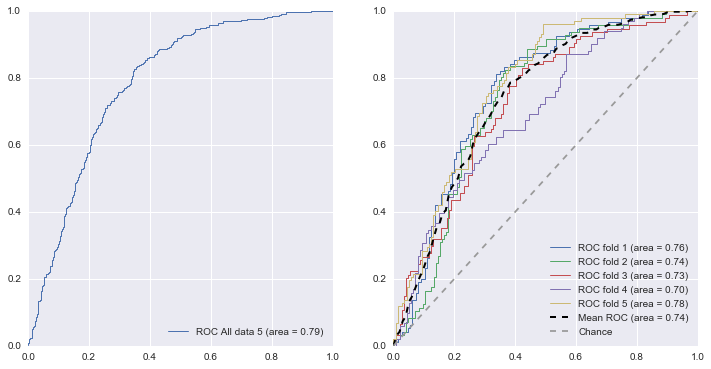

In [173]:
# Repeat but only on logistic regression. Trying to see what's going on
cv = KFold(len(resp), n_folds=5,shuffle=True)

lg = LogisticRegression()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

fig, ax = plt.subplots(1,2,figsize=(12,6))

# Plot one time, all data version
probas_ = lg.fit(pred, resp).predict_proba(pred)
# Compute ROC curve and area the curve
fpr, tpr, thresholdsl = metrics.roc_curve(resp, probas_[:,1])
roc_auc = metrics.auc(fpr, tpr)
ax[0].plot(fpr, tpr, lw=1, label='ROC All data %d (area = %0.2f)' % (i+1, roc_auc))
ax[0].legend(loc=4)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    # Logisitic regression
    probas_ = lg.fit(pred.values[train], resp.values[train]).predict_proba(pred.values[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholdsl = metrics.roc_curve(resp.values[test], probas_[:,1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0

    roc_auc = metrics.auc(fpr, tpr)
    ax[1].plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))


mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
ax[1].plot(mean_fpr, mean_tpr, 'k--',
label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
ax[1].plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
ax[1].legend(loc=4)
    

/Users/mathew/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


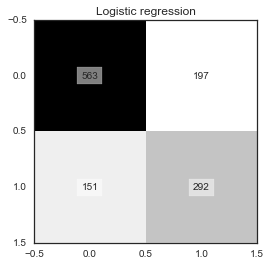

In [194]:
#  Confusion matrices
output = lr2.fit(pred.values,resp.values).predict(pred.values)
cm_lr = confusion_matrix(resp.values,output)

# Get mouse's choice
output_mouse = 

fig, ax = plt.subplots(1,2)

with sns.axes_style("white"):
    ax[0].imshow(cm_lr,interpolation='none',cmap="Greys")
    ax[0].title('Logistic regression')
    
    for i in range(0,2):
        for j in range(0,2):
            ax[0].text(i, j, cm_lr[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))
            
    ax[1].imshow(cm_lr,interpolation='none',cmap="Greys")
    ax[1].title('Logistic regression')
    
    for i in range(0,2):
        for j in range(0,2):
            ax[1].text(i, j, cm_lr[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

In [192]:
print(tt.values[1000:1010])

[[2]
 [3]
 [3]
 [2]
 [2]
 [1]
 [2]
 [3]
 [1]
 [1]]


In [ ]:
lr = LogisticRegression

In [14]:
# Classify differently

In [ ]:
# Create confusion matrices

In [199]:
theta = pd.read_csv('~/work/whiskfree/data/theta_' + mouse_name + '.csv',header=None)
kappa = pd.read_csv('~/work/whiskfree/data/kappa_' + mouse_name + '.csv',header=None)
tt = pd.read_csv('~/work/whiskfree/data/trialtype_' + mouse_name + '.csv',header=None)

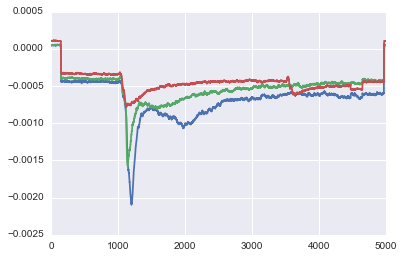

In [211]:
plt.plot(np.mean(kappa[tt.squeeze()==1],0))
plt.plot(np.mean(kappa[tt.squeeze()==2],0))
plt.plot(np.mean(kappa[tt.squeeze()==3],0))

In [212]:
k1 = kappa[tt.squeeze()==1] 
k2 = kappa[tt.squeeze()==2] 
k3 = kappa[tt.squeeze()==3] 


(613, 5000)